In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

## 목표
> * 대한민국의 주요 경제 지수중 하나인 KOSPI 선형회귀분석과 모델 튜닝을 통해 내일의 코스피를 예측해 볼것이다.
> * 코스피는 한국 주식 시장 지수로 구낸 증권 거래소에 상장된 대형 기업들의 주가 변동을 반영한다.
> * 이를 통해 코스피의 상승은 전반적인 경제 성장과 경기 호황을 의미하고 코시피의 하향은 경기 침체, 경제 불확실성, 또는 기업 실적 부진을 알 수 있다.

## 코스피 데이터 갖고 오기

In [141]:
kospi = yf.download('^KS11')
kospi.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


<AxesSubplot: xlabel='Date', ylabel='Adj Close'>

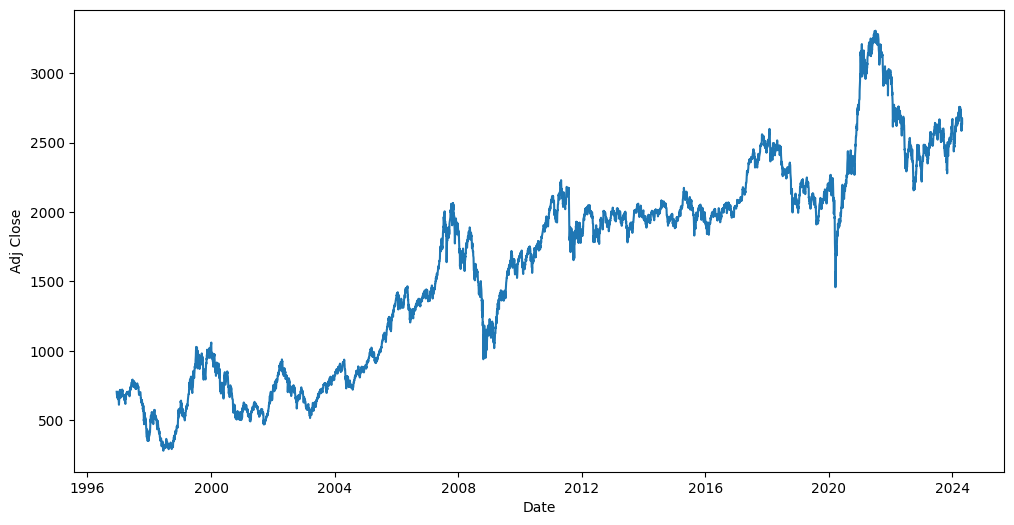

In [144]:
plt.figure(figsize =(12,6))
sns.lineplot(data=kospi, x='Date', y='Adj Close')

<AxesSubplot: xlabel='Adj Close', ylabel='Count'>

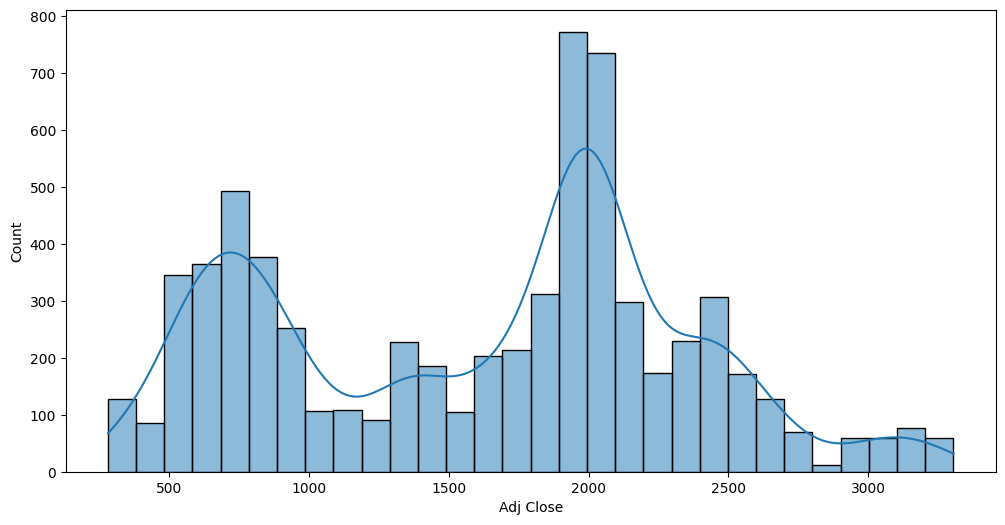

In [145]:
plt.figure(figsize =(12,6))
sns.histplot(data=kospi, x='Adj Close', bins=30, kde=True)

<AxesSubplot: xlabel='Volume', ylabel='Count'>

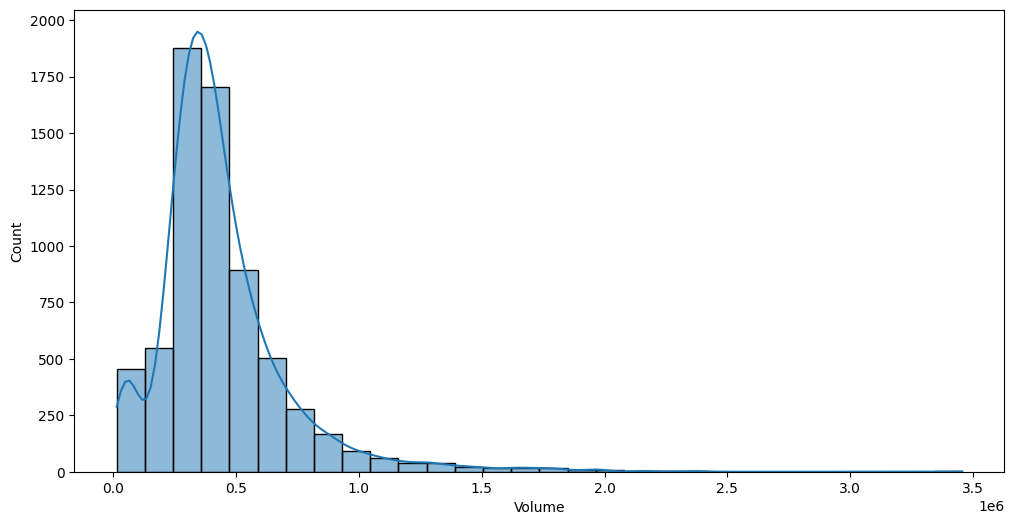

In [160]:
plt.figure(figsize =(12,6))
sns.histplot(data=kospi, x='Volume', bins=30, kde=True)

In [146]:
dayofweek = kospi['Date'].dt.dayofweek
year = kospi['Date'].dt.year
month = kospi['Date'].dt.month
ema9 = kospi['Close'].ewm(span=9, adjust=False).mean()
ema20 = kospi['Close'].ewm(span=20, adjust=False).mean()
ema50 = kospi['Close'].ewm(span=50, adjust=False).mean()

In [147]:
kospi.insert(1, 'Year', year)
kospi.insert(2, 'Month', month)
kospi.insert(3, 'Dayofweek', dayofweek)
kospi.insert(4, 'EMA9', ema9)
kospi.insert(5, 'EMA20', ema20)
kospi.insert(6, 'EMA50', ema50)

In [148]:
kospi

,Date,Year,Month,Dayofweek,EMA9,EMA20,EMA50,Open,High,Low,Close,Adj Close,Volume
0,1996-12-11,1996,12,2,704.679993,704.679993,704.679993,705.989990,709.479980,704.429993,704.679993,704.679993,28000
1,1996-12-12,1996,12,3,701.619995,703.222851,704.079993,705.109985,706.010010,688.739990,689.380005,689.380005,25900
2,1996-12-13,1996,12,4,699.109998,701.874961,703.491366,690.440002,695.719971,677.640015,689.070007,689.070007,26500
3,1996-12-16,1996,12,0,694.071995,699.212582,702.331704,686.969971,686.969971,667.710022,673.919983,673.919983,22800
4,1996-12-17,1996,12,1,687.927591,695.797096,700.803009,675.349976,680.090027,660.390015,663.349976,663.349976,31600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6741,2024-04-19,2024,4,4,2645.551137,2673.423295,2660.342467,2600.689941,2609.899902,2553.550049,2591.860107,2591.860107,809500
6742,2024-04-22,2024,4,0,2642.328898,2669.234404,2659.130603,2615.719971,2629.439941,2604.370117,2629.439941,2629.439941,401900
6743,2024-04-23,2024,4,1,2638.467122,2664.833034,2657.714502,2632.149902,2641.780029,2619.719971,2623.020020,2623.020020,430300
6744,2024-04-24,2024,4,2,2645.923698,2665.872745,2658.421776,2662.840088,2677.850098,2662.840088,2675.750000,2675.750000,325100


In [155]:
kospi = kospi[['Month', 'Dayofweek', 'Volume','Adj Close']]
kospi.head()

,Month,Dayofweek,Volume,Adj Close
0,12,2,28000,704.679993
1,12,3,25900,689.380005
2,12,4,26500,689.070007
3,12,0,22800,673.919983
4,12,1,31600,663.349976


In [156]:
kospi_encoded = pd.get_dummies(kospi, drop_first=True)
kospi_encoded.head()

,Month,Dayofweek,Volume,Adj Close
0,12,2,28000,704.679993
1,12,3,25900,689.380005
2,12,4,26500,689.070007
3,12,0,22800,673.919983
4,12,1,31600,663.349976


In [157]:
y_column = ['Adj Close']
X = kospi_encoded.drop(y_column, axis=1)
y = kospi_encoded[y_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2024)

In [161]:
encoded_columns = list(set(kospi_encoded.columns) - set(kospi_encoded.columns)) # ['region_southwest', 'region_southeast', 'region_northwest', 'smoker_yes', 'sex_male']
continuous_columns = list(set(kospi_encoded.columns) - set(encoded_columns) - set(y_column)) 

In [162]:
scaler = StandardScaler()

In [164]:
X_train_continuous = scaler.fit_transform(X_train[continuous_columns])
X_test_continuous = scaler.fit_transform(X_test[continuous_columns])
X_train_continuous_df = pd.DataFrame(X_train_continuous, columns=continuous_columns)
X_test_continuous_df = pd.DataFrame(X_test_continuous, columns=continuous_columns)
X_train_categorical_df = X_train[encoded_columns].reset_index(drop=True)
X_test_categorical_df = X_test[encoded_columns].reset_index(drop=True)

X_train_final = pd.concat([X_train_continuous_df, X_train_categorical_df], axis=1)
X_test_final = pd.concat([X_test_continuous_df, X_test_categorical_df], axis=1)

In [165]:
model = LinearRegression()
model.fit(X_train_final, y_train)

LinearRegression()

In [167]:
init_learing_rate = 0.001
schedular = 'constant'
epoch = 1000
penalty = None
sgd_reg = SGDRegressor(max_iter=epoch,
                       eta0=init_learing_rate,
                       learning_rate=schedular,
                       penalty=penalty,
                       random_state=1234)
sgd_reg.fit(X_train_final, y_train.values.flatten())

SGDRegressor(eta0=0.001, learning_rate='constant', penalty=None,
             random_state=1234)

In [169]:
from sklearn.metrics import mean_squared_error

y_train_pred = sgd_reg.predict(X_train_final)
y_test_pred = sgd_reg.predict(X_test_final)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print('[SGD] 학습 데이터 MSE 값 :', mse_train)
print('[SGD] 평가 데이터 MSE 값 :', mse_test)
print('-'*50)

print('[기존] 학습 데이터 MSE 값 :', mean_squared_error(y_train, model.predict(X_train_final)))
print('[기존] 평가 데이터 MSE 값 :', mean_squared_error(y_test, model.predict(X_test_final)))

[SGD] 학습 데이터 MSE 값 : 461748.2705017623
[SGD] 평가 데이터 MSE 값 : 497359.97944162035
--------------------------------------------------
[기존] 학습 데이터 MSE 값 : 461308.7897875933
[기존] 평가 데이터 MSE 값 : 496675.319311041


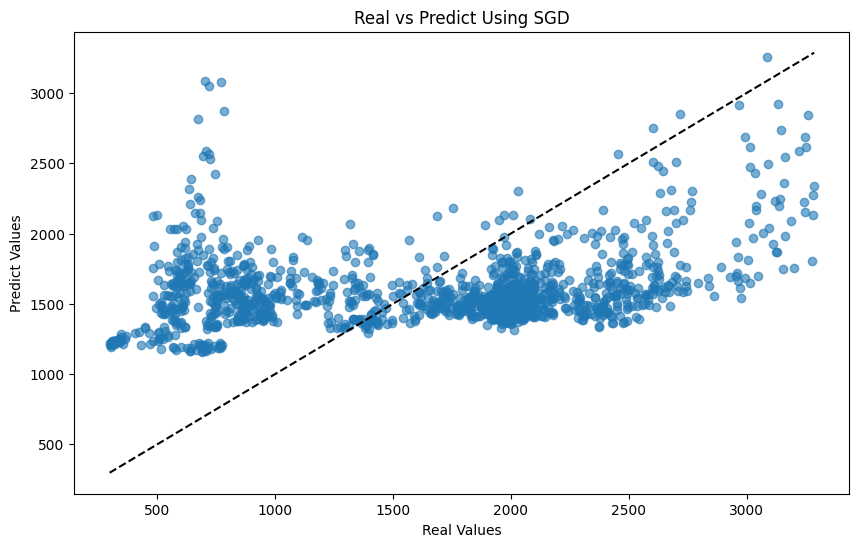

In [170]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Real Values')
plt.ylabel('Predict Values')
plt.title('Real vs Predict Using SGD')
plt.show()

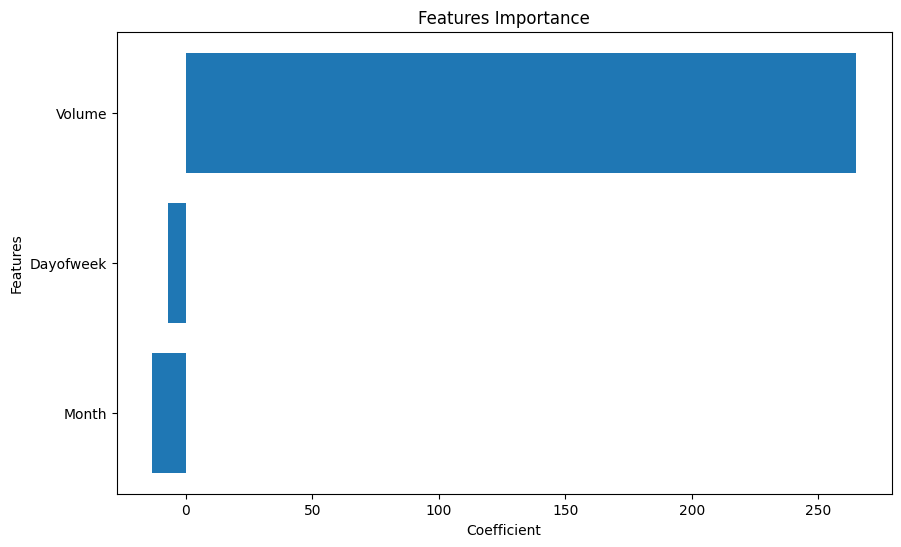

In [171]:
plt.figure(figsize=(10, 6))
plt.barh(X_train_final.columns, sgd_reg.coef_.flatten())
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Features Importance')
plt.show()

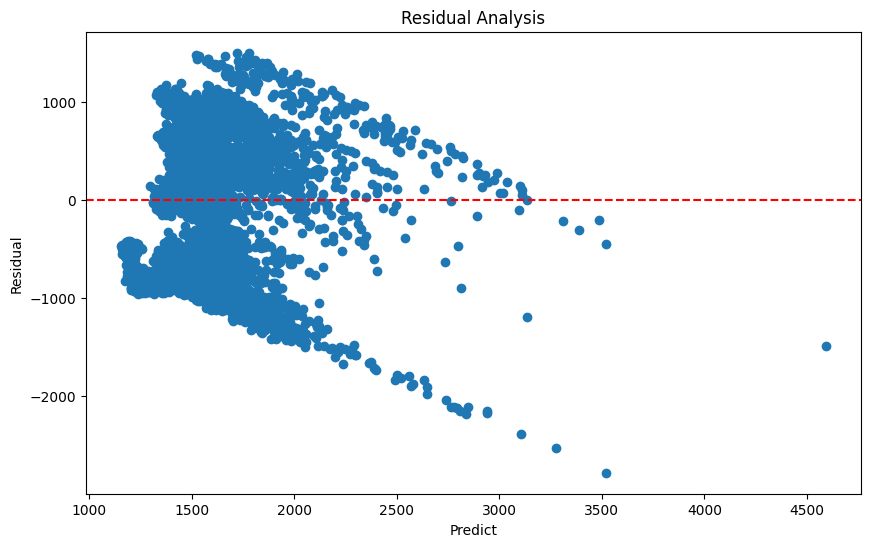

In [172]:
# 잔차 분석
y_pred = sgd_reg.predict(X_train_final)
residuals = y_train.values.flatten() - y_pred

# 잔차 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predict')
plt.ylabel('Residual')
plt.title('Residual Analysis')
plt.show()

In [173]:
from sklearn.model_selection import GridSearchCV
init_learing_rate = 0.001
schedular = 'constant'
epoch = 1000
penalty = None

sgd_reg = SGDRegressor(max_iter=epoch,
                       eta0=init_learing_rate,
                       learning_rate=schedular,
                       penalty=penalty,
                       random_state=42)
# SGDRegressor의 하이퍼파라미터 그리드 설정
param_grid = {
    'max_iter': [1000],  # 최대 반복 횟수
    'eta0' : [1, 0.1, 0.01, 0.001, 0.0001, 0.00001], # 초기 학습률
    'penalty': ['l2', 'l1', None]  # 규제 종류
}

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(SGDRegressor(random_state=42),
                           param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_final, y_train.values.flatten())


GridSearchCV(estimator=SGDRegressor(random_state=42), n_jobs=-1,
             param_grid={'eta0': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'max_iter': [1000], 'penalty': ['l2', 'l1', None]},
             scoring='neg_mean_squared_error')

In [174]:
grid_search.best_params_

{'eta0': 0.0001, 'max_iter': 1000, 'penalty': 'l1'}

In [175]:
grid_search.best_score_

-462275.3872928424

In [176]:
# 전체 결과 분석
results = pd.DataFrame(grid_search.cv_results_)

# 관심 있는 컬럼만 선택하여 정리
# 예를 들어, 'mean_test_score', 'param_eta0', 'param_penalty' 등
columns_of_interest = ['mean_test_score', 'param_eta0', 'param_penalty']
results = results[columns_of_interest]

# 'mean_test_score'를 기준으로 정렬
results = results.sort_values(by='mean_test_score', ascending=False)

# 결과 출력
results.head()

,mean_test_score,param_eta0,param_penalty
13,-462275.387293,0.0001,l1
14,-462275.393482,0.0001,None
12,-462276.002201,0.0001,l2
9,-462286.629367,0.001,l2
10,-462286.895319,0.001,l1
